<a href="https://www.kaggle.com/code/emigiupponi/btc-ranking-prices-in-argentina?scriptVersionId=142249513" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

https://www.nylas.com/blog/use-python-requests-module-rest-apis/

# Ranking of the final prices -including commissions- of the principal brokers or exchanges of interest in argentina

https://www.nylas.com/blog/use-python-requests-module-rest-apis/

NOTAS: en el código se puede restringuir el período a días específicos (útil para gráficos pasados). 
Se está excluyendo a RipioExchange porque el spread es muy grande.

# Day information

In [1]:
#pip install requests

In [2]:
import requests
from datetime import date, datetime, timedelta
import pandas as pd
import numpy as np

In [3]:
response = requests.get('https://criptoya.com/api/btc/ars/0.1')
print(response)

<Response [200]>


In [4]:
json = response.json()
df = pd.DataFrame(json)

In [5]:
df

,argenbtc,buenbit,ripio,ripioexchange,satoshitango,cryptomkt,decrypto,latamex,bitso,letsbit,...,lemoncash,bitmonedero,belo,tiendacrypto,saldo,kriptonmarket,calypso,bybit,binance,trubit
ask,1.935675e+07,19412600,1.965082e+07,3.956857e+07,2.018358e+07,1.898530e+07,1.949376e+07,1.932278e+07,1.918209e+07,1.997503e+07,...,1.967236e+07,1.952949e+07,1.927021e+07,1.959281e+07,1.957949e+07,1.939168e+07,1.949473e+07,1.925889e+07,1.950160e+07,1.943796e+07
totalAsk,1.935675e+07,19412600,1.974907e+07,3.976641e+07,2.038541e+07,1.911640e+07,1.956199e+07,1.961262e+07,1.929718e+07,1.997503e+07,...,1.986908e+07,1.952949e+07,1.927021e+07,1.959281e+07,1.957949e+07,1.969597e+07,1.949473e+07,1.945148e+07,1.951623e+07,1.943796e+07
bid,1.884057e+07,19055300,1.872056e+07,1.512457e+07,1.917284e+07,1.861475e+07,1.887491e+07,1.904011e+07,1.907777e+07,1.881489e+07,...,1.910526e+07,1.821414e+07,1.813005e+07,1.894831e+07,1.852156e+07,1.863122e+07,1.797307e+07,1.879833e+07,1.879346e+07,1.894117e+07
totalBid,1.884057e+07,19055300,1.862695e+07,1.504894e+07,1.898111e+07,1.848641e+07,1.880885e+07,1.884971e+07,1.896331e+07,1.881489e+07,...,1.900973e+07,1.794093e+07,1.813005e+07,1.894831e+07,1.852156e+07,1.834311e+07,1.797307e+07,1.879833e+07,1.859157e+07,1.894117e+07
time,1.694099e+09,1694098940,1.694099e+09,1.694099e+09,1.694099e+09,1.694099e+09,1.694099e+09,1.694099e+09,1.694099e+09,1.694099e+09,...,1.694099e+09,1.694099e+09,1.694099e+09,1.694099e+09,1.694099e+09,1.694099e+09,1.694099e+09,1.694099e+09,1.694099e+09,1.694099e+09


In [6]:
# Excluir a RipioExchange
df.drop('ripioexchange', axis=1, inplace=True)

In [7]:
df_transposed = df.T
df_transposed.columns = ['Buying', 'Buying (final)', 'Selling', 'Selling (final)', 'Timestamp']
df_transposed['spread'] = df_transposed["Buying (final)"] - df_transposed["Selling (final)"]

In [8]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [9]:
# Create subplots and mention plot grid size
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
               vertical_spacing=0.03, subplot_titles=('Prices', 'Spread'), 
               row_width=[0.2, 0.7])

# Plot OHLC on 1st row

# Add traces for 'Compra' and 'Venta'
fig.add_trace(
    go.Scatter(x=df_transposed.index, y=df_transposed['Selling (final)'], name='Compra', line=dict(color='#8497B0')),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=df_transposed.index, y=df_transposed['Buying (final)'], name='Venta', line=dict(color='#F4B183')),
    row=1, col=1
)

# Bar trace for volumes on 2nd row without legend

# Add traces for 'Spread %'
fig.add_trace(
    go.Scatter(x=df_transposed.index, y=df_transposed['spread'], name='Spread %', line=dict(color='#81BB59')),
    row=2, col=1
)

# Do not show OHLC's rangeslider plot 
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

# Building an historical serie day by day

In [10]:
import requests
import pandas as pd
from datetime import date
import os

# Definir la URL de la API y realizar la solicitud
url = "https://criptoya.com/api/btc/ars/0.1"
response = requests.get(url)
json_data = response.json()

# Extraer los campos relevantes y crear un diccionario de precios
platform_prices = {}
for platform, data in json_data.items():
    platform_prices[platform] = {
        'totalAsk': data['totalAsk'],
        'totalBid': data['totalBid']
    }

# Crear un DataFrame y agregar una columna con la fecha actual
df = pd.DataFrame(platform_prices).T
df['date'] = date.today()

# Guardar el DataFrame en una tabla o archivo CSV
df.to_csv('tabla.csv', index=True, mode='a', header=not os.path.exists('tabla.csv'))

In [11]:
df

,totalAsk,totalBid,date
argenbtc,19356750.41,18840570.00,2023-09-07
buenbit,19412600.00,19055300.00,2023-09-07
ripio,19749069.87,18626953.34,2023-09-07
ripioexchange,39766409.87,15048944.69,2023-09-07
satoshitango,20385413.51,18981108.46,2023-09-07
cryptomkt,19116400.19,18486412.21,2023-09-07
decrypto,19561990.57,18808850.61,2023-09-07
latamex,19612619.72,18849706.45,2023-09-07
bitso,19297177.99,18963306.98,2023-09-07
letsbit,19975030.95,18814887.00,2023-09-07


In [12]:
import requests
import pandas as pd
from datetime import date
import os

# Definir la URL de la API y realizar la solicitud
url = "https://criptoya.com/api/btc/ars/0.1"
response = requests.get(url)
json_data = response.json()

# Extraer los campos relevantes y crear un diccionario de precios
platform_prices = {}
for platform, data in json_data.items():
    platform_prices[platform] = {
        'totalAsk': data['totalAsk'],
        'totalBid': data['totalBid']
    }

# Crear un DataFrame con los nuevos datos y agregar una columna con la fecha actual
new_data = pd.DataFrame(platform_prices).T
new_data['date'] = date.today()

# Crear un nombre de archivo basado en la fecha actual
file_name = f"tabla_{date.today()}.csv"

# Guardar el DataFrame en un archivo CSV separado por día
new_data.to_csv(file_name, index=True)

# Enviar a S3

In [13]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("AWSAccessKeyId")
secret_value_1 = user_secrets.get_secret("AWSSecretKey")

In [14]:
import requests
import pandas as pd
from datetime import datetime, date
import os
import boto3
import s3fs
import pytz

# Define the timezone for Buenos Aires
ba_timezone = pytz.timezone('America/Argentina/Buenos_Aires')

# Get the current datetime in the Buenos Aires timezone
ba_datetime = datetime.now(ba_timezone)

# Extract the date part from the datetime object
current_date = ba_datetime.date()

# Format the date as YYYY-MM-DD
current_date_str = current_date.strftime('%Y-%m-%d')

# Construct the filename with the current date
filename = f'tabla_{current_date_str}.csv'

# Definir la URL de la API y realizar la solicitud
url = "https://criptoya.com/api/btc/ars/0.1"
response = requests.get(url)
json_data = response.json()

# Extraer los campos relevantes y crear un diccionario de precios
platform_prices = {}
for platform, data in json_data.items():
    platform_prices[platform] = {
        'totalAsk': data['totalAsk'],
        'totalBid': data['totalBid']
    }

# Create a DataFrame and add a column with the current date
df = pd.DataFrame(platform_prices).T
df['date'] = current_date

# Save the DataFrame to a CSV file with the current date in the name
df.to_csv(filename, index=True)

# Configurar las credenciales de AWS
access_key = secret_value_0
secret_key = secret_value_1
bucket_name = 'btcpricesinargentina'

# Crear el cliente de S3
s3_client = boto3.client('s3', aws_access_key_id=access_key, aws_secret_access_key=secret_key)

# Verificar si el bucket ya existe
response = s3_client.list_buckets()
existing_buckets = [bucket['Name'] for bucket in response['Buckets']]
if bucket_name not in existing_buckets:
    # El bucket no existe, se puede crear
    s3_client.create_bucket(Bucket=bucket_name)

# Subir el archivo CSV a S3
s3_client.upload_file(filename, bucket_name, filename)

# Importar datos de S3

In [15]:
import pandas as pd
import boto3
import io

# Configurar las credenciales de AWS
access_key = secret_value_0
secret_key = secret_value_1
bucket_name = 'btcpricesinargentina'

# Crear el cliente de S3
s3_client = boto3.client('s3', aws_access_key_id=access_key, aws_secret_access_key=secret_key)

# Obtener la lista de objetos en el bucket
response = s3_client.list_objects(Bucket=bucket_name)
objects = response['Contents']

# Leer los archivos CSV y combinarlos en un DataFrame
dataframes = []
for obj in objects:
    if obj['Key'].startswith('tabla_'):
        # Descargar el archivo CSV desde S3
        obj_data = s3_client.get_object(Bucket=bucket_name, Key=obj['Key'])
        csv_data = obj_data['Body'].read()

        # Crear un DataFrame a partir del archivo CSV
        df = pd.read_csv(io.BytesIO(csv_data))
        dataframes.append(df)

# Combinar los DataFrames en uno solo
combined_df = pd.concat(dataframes)

# Convertir la columna de fecha a tipo datetime
combined_df['date'] = pd.to_datetime(combined_df['date'])

# Restringir la importación de datos al rango de fechas deseado
# start_date = pd.Timestamp('2023-06-14')
# end_date = pd.Timestamp('2023-06-22')
# combined_df = combined_df[(combined_df['date'] >= start_date) & (combined_df['date'] <= end_date)]

# Calcular el spread diario
combined_df['spread'] = combined_df['totalAsk'] - combined_df['totalBid']

# Excluir la empresa "ripioexchange"
combined_df = combined_df[combined_df['Unnamed: 0'] != 'ripioexchange']

# Agrupar por fecha y calcular el promedio, compra y venta diarios
daily_avg_spread = combined_df.groupby('date')['spread'].mean()
daily_avg_ask = combined_df.groupby('date')['totalAsk'].mean()
daily_avg_bid = combined_df.groupby('date')['totalBid'].mean()

# Calcular el promedio de compra y venta diario
daily_avg_price = (daily_avg_ask + daily_avg_bid) / 2

# Calcular el porcentaje del spread respecto al promedio de compra y venta diario
daily_spread_percentage = (daily_avg_spread / daily_avg_price)

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# Calcular las desviaciones estándar diarias
daily_std_ask = daily_avg_ask.std()
daily_std_bid = daily_avg_bid.std()
daily_std_spread = daily_avg_spread.std()
daily_std_spread_percentage = daily_spread_percentage.std()

# Excel para web

In [16]:
import pandas as pd
import openpyxl

# Convertir el índice a formato de fecha
dates = pd.to_datetime(daily_avg_ask.index)
formatted_dates = dates.strftime('%d-%b-%Y')

# Crear un DataFrame con los datos calculados
data = {
    'Fecha': formatted_dates,  # Columna de fechas en el formato "dd-mmm-yyyy"
    'Compra': daily_avg_ask.values,  # Columna de precios de compra
    'Venta': daily_avg_bid.values,  # Columna de precios de venta
    'Spread': daily_spread_percentage.values,  # Columna de spread
    'SD Compra': daily_std_ask,  # Desviación estándar de precios de compra
    'SD Venta': daily_std_bid,  # Desviación estándar de precios de venta
    'SD Spread': daily_std_spread_percentage  # Desviación estándar de spread
}

df = pd.DataFrame(data)

# Crear un nuevo libro de Excel
workbook = openpyxl.Workbook()

# Hoja de datos
data_sheet = workbook.active
data_sheet.title = 'Datos'

# Escribir los encabezados en la hoja de datos
headers = list(df.columns)
data_sheet.append(headers)

# Escribir los datos en la hoja de datos
for _, row in df.iterrows():
    data_sheet.append(row.tolist())

# Guardar el libro de Excel
excel_file = 'web_cripto_spread.xlsx'
workbook.save(excel_file)

# Gráfico diario

Estático

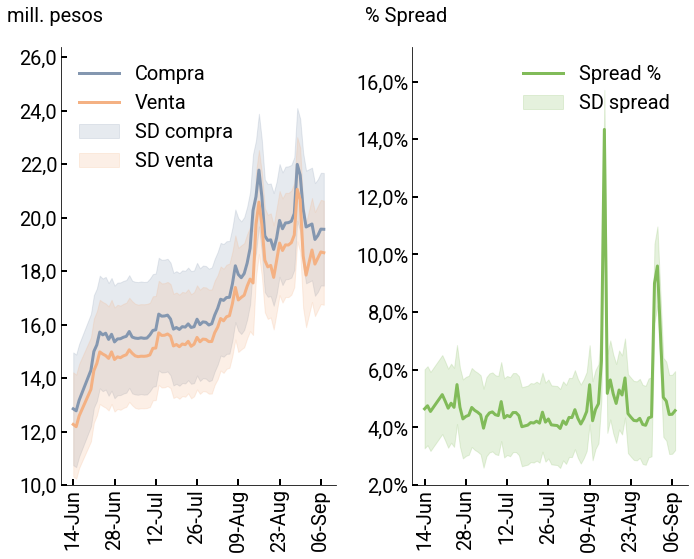

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import locale
import requests
from matplotlib import font_manager
from io import BytesIO
import tempfile
import matplotlib.ticker as ticker


# Obtener las fechas en formato datetime
dates = pd.to_datetime(daily_avg_ask.index)

# Descargar la fuente Roboto desde la web
font_url = 'https://github.com/google/fonts/blob/main/apache/roboto/static/Roboto-Regular.ttf?raw=true'
font_data = requests.get(font_url).content

# Guardar el contenido de la fuente en un archivo temporal
with tempfile.NamedTemporaryFile(suffix='.ttf', delete=False) as tmp_file:
    tmp_file.write(font_data)
    font_path = tmp_file.name

# Registrar la fuente Roboto en matplotlib
font_manager.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Roboto'

# Crear los subplots
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8), sharex=True)

# Subplot superior: Precios de compra y venta
ax1.plot(dates, daily_avg_ask.values, label='Compra', color='#8497B0', linewidth=3)
ax1.plot(dates, daily_avg_bid.values, label='Venta', color='#F4B183', linewidth=3)
ax1.fill_between(dates, daily_avg_ask.values - daily_std_ask, daily_avg_ask.values + daily_std_ask, color='#8497B0', alpha=0.2, label='SD compra')
ax1.fill_between(dates, daily_avg_bid.values - daily_std_bid, daily_avg_bid.values + daily_std_bid, color='#F4B183', alpha=0.2, label='SD venta')
ax1.set_ylabel('mill. pesos', fontsize=20)
ax1.yaxis.get_label().set_rotation(0)
ax1.yaxis.get_label().set_verticalalignment('center')
ax1.yaxis.set_label_coords(-0.02, 1.07)
ax1.legend(fontsize=20, frameon=False)

# Subplot inferior: Porcentaje de spread
ax2.plot(dates, daily_spread_percentage.values, label='Spread %', color='#81BB59', linewidth=3)
ax2.fill_between(dates, daily_spread_percentage.values - daily_std_spread_percentage, daily_spread_percentage.values + daily_std_spread_percentage, color='#81BB59', alpha=0.2, label='SD spread')
ax2.set_ylabel('% Spread', fontsize=20)
ax2.yaxis.set_major_formatter(ticker.PercentFormatter())
ax2.yaxis.get_label().set_rotation(0)
ax2.yaxis.get_label().set_verticalalignment('center')
ax2.yaxis.set_label_coords(-0.02, 1.07)
ax2.legend(fontsize=20, frameon=False)

# Ajustar las marcas de graduación en los ejes x
ax1.tick_params(axis='x', direction='in', length=6, width=2, colors='black')
ax2.tick_params(axis='x', direction='in', length=6, width=2, colors='black')

# Ajustar las marcas de graduación en los ejes y
ax1.tick_params(axis='y', direction='in', length=6, width=2, colors='black', labelrotation=0)
ax2.tick_params(axis='y', direction='in', length=6, width=2, colors='black', labelrotation=0)

# Ajustar formato de fecha en el eje x
date_format = mdates.DateFormatter('%d-%b')
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax1.xaxis.set_major_formatter(date_format)
ax1.xaxis.set_tick_params(rotation=90)
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax2.xaxis.set_major_formatter(date_format)
ax2.xaxis.set_tick_params(rotation=90)

# Función para formatear los números en millones con separador de miles como coma y separador de decimales como punto
def format_millions(x, _):
    return "{:,.1f}".format(x/1000000).replace(",", " ").replace(".", ",")

# Función para formatear los números como porcentajes con separador de miles como coma
def format_percentages(x, _):
    return "{:,.1%}".format(x).replace(",", " ").replace(".", ",")

# Configurar la escala en millones en el subplot superior
ax1.yaxis.set_major_formatter(plt.FuncFormatter(format_millions))

# Configurar la escala en porcentajes en el subplot inferior
ax2.yaxis.set_major_formatter(plt.FuncFormatter(format_percentages))

# Ajustar tamaño de letra en los ejes
ax1.tick_params(axis='both', labelsize=20)
ax2.tick_params(axis='both', labelsize=20)

# Ajustar el tamaño de las leyendas
legend_font = {'family': 'Roboto', 'size': 20}
ax1.legend(fontsize=20, frameon=False, prop=legend_font)
ax2.legend(fontsize=20, frameon=False, prop=legend_font)

# Ajustar espacio entre subplots
fig2.tight_layout(pad=2)

# Configurar el fondo transparente
fig2.patch.set_alpha(0)

# Eliminar recuadro del gráfico
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(True)

ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(True)

# Ajustar límites del eje y
ax1.set_ylim(10000000, daily_avg_ask.max() * 1.2)
ax2.set_ylim(0.02, daily_spread_percentage.max() * 1.2)

# Guardar el gráfico como imagen PNG con fondo transparente
plt.savefig('spreads.png', format='png', transparent=True)

# Mostrar el gráfico
plt.show()

Dinámico

In [18]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Crear los subplots
fig3 = make_subplots(rows=1, cols=2, shared_xaxes=True)

# Subplot superior: Precios de compra y venta
fig3.add_trace(go.Scatter(x=daily_avg_ask.index, y=daily_avg_ask.values, name='Compra', line=dict(color='#8497B0', width=3)), row=1, col=1)
fig3.add_trace(go.Scatter(x=daily_avg_bid.index, y=daily_avg_bid.values, name='Venta', line=dict(color='#F4B183', width=3)), row=1, col=1)
fig3.add_trace(go.Scatter(x=daily_avg_ask.index, y=daily_avg_ask.values + daily_std_ask, fill='tonexty', mode='none', fillcolor='rgba(132, 151, 176, 0.2)', showlegend=False), row=1, col=1)
fig3.add_trace(go.Scatter(x=daily_avg_ask.index, y=daily_avg_ask.values - daily_std_ask, fill='tonexty', mode='none', fillcolor='rgba(132, 151, 176, 0.2)', showlegend=False), row=1, col=1)
fig3.add_trace(go.Scatter(x=daily_avg_bid.index, y=daily_avg_bid.values + daily_std_bid, fill='tonexty', mode='none', fillcolor='rgba(244, 177, 131, 0.2)', showlegend=False), row=1, col=1)
fig3.add_trace(go.Scatter(x=daily_avg_bid.index, y=daily_avg_bid.values - daily_std_bid, fill='tonexty', mode='none', fillcolor='rgba(244, 177, 131, 0.2)', showlegend=False), row=1, col=1)

# Subplot inferior: Porcentaje de spread
fig3.add_trace(go.Scatter(x=daily_spread_percentage.index, y=daily_spread_percentage.values, name='Spread %', line=dict(color='#81BB59', width=3)), row=1, col=2)
fig3.add_trace(go.Scatter(x=daily_spread_percentage.index, y=daily_spread_percentage.values - daily_std_spread_percentage, fill='tonexty', mode='none', fillcolor='rgba(129, 187, 89, 0.2)', showlegend=False), row=1, col=2)
fig3.add_trace(go.Scatter(x=daily_spread_percentage.index, y=daily_spread_percentage.values + daily_std_spread_percentage, fill='tonexty', mode='none', fillcolor='rgba(129, 187, 89, 0.2)', showlegend=False), row=1, col=2)

# Configurar el diseño del gráfico
fig3.update_layout(
    title='Gráfico de Spread',
    yaxis=dict(
        title='mill. pesos',
        title_standoff=25,
        title_font=dict(size=18),
        tickformat='~s'
    ),
    yaxis2=dict(
        title='% Spread',
        title_standoff=25,
        title_font=dict(size=18),
        tickformat=',.1%',
        overlaying='y',
        side='right'
    ),
    xaxis=dict(
        title='Fecha',
        tickangle=90,
        tickformat='%d-%b'
    ),
    legend=dict(
        x=0,
        y=1,
        traceorder='normal',
        font=dict(size=12),
        bgcolor='rgba(0,0,0,0)'
    ),
    margin=dict(l=50, r=50, t=50, b=50),
    showlegend=True
)

# Mostrar el gráfico interactivo
fig3.show()

## Sending to the monitor page

In [19]:
pip install chart_studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [20]:
import chart_studio

In [21]:
import chart_studio.plotly as py

In [22]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_2 = user_secrets.get_secret("CHARTSTUDIO_API_KEY")
secret_value_3 = user_secrets.get_secret("CHARTSTUDIO_BCRA_API_KEY")

In [23]:
chart_studio.tools.set_credentials_file(username='emigiupponi', 
                                        api_key=secret_value_2)
py.plot(fig, filename = 'arg-prices', auto_open=True)

'https://plotly.com/~emigiupponi/68/'

In [24]:
chart_studio.tools.set_credentials_file(username='crypto-financial-stability-monitor', 
                                        api_key=secret_value_3)
py.plot(fig, filename = 'arg-prices', auto_open=True)

'https://plotly.com/~crypto-financial-stability-monitor/33/'

In [25]:
chart_studio.tools.set_credentials_file(username='crypto-financial-stability-monitor', 
                                        api_key=secret_value_3)
py.plot(fig3, filename = 'arg-prices-times-series', auto_open=True)

'https://plotly.com/~crypto-financial-stability-monitor/282/'